In [1]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

In [2]:
df = pd.read_csv('data/train_new.csv').rename({'target': 'value'}, axis=1)

In [7]:
def create_features(df):

    week_info = df.groupby('Период_неделя')['value'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    df = df.merge(week_info, how='left', right_index=True, left_on='Период_неделя')
    df['week_sum'] -= df['value']
    df['week_count'] -= 1
    df['feature_mean_week'] = df['week_sum'] / df['week_count']
    df['feature_mean_week_norm'] = df['feature_mean_week'] / df['value']

    # df['feature_']

    for i in range(28):
        df[f'target_{i+1}'] = df['value'].shift(-i) / df['value'].shift(1)

    for i in range(1, 8):
        df[f'feature_{i}_weeks_ago'] = df['value'].shift(i) / df['value'].shift(i+1)
    
    for i in [7, 13, 20]: #, 30, 50]:
        df[f'feature_big_diff_{i}_weeks'] = df['value'].shift(1) / df['value'].shift(i)

    bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)
df = df.dropna().reset_index(drop=True)

In [9]:
test_size = 0.4

train_data, valid_data = df[:int(len(df) * (1-test_size))], df[int(len(df) * (1-test_size)):]

all_metrics = []
all_preds = []
for i in range(1, 29):
    print(f'Предсказываение на {i} недель вперед')
    X_train, y_train = train_data.drop([x for x in train_data.columns if 'target' in x], axis=1), train_data[f'target_{i}']
    X_valid, y_valid = valid_data.drop([x for x in valid_data.columns if 'target' in x], axis=1), valid_data[f'target_{i}']


    model = CatBoostRegressor(
        depth=3,
        iterations=3000,
        loss_function='MAPE',
        eval_metric='R2',

        random_state=42,
        thread_count=4,
        early_stopping_rounds=500
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

    preds = model.predict(X_valid)
    all_preds.append(preds)

    r2_metric = metrics.r2_score(y_valid, preds)
    mape_metric = metrics.mean_absolute_percentage_error(y_valid, preds)
    all_metrics.append([r2_metric, mape_metric])

    print(f'R2: {round(r2_metric, 5)}')
    print(f'MAPE: {round(mape_metric, 5)}')
    
    print()

Предсказываение на 1 недель вперед
R2: 0.37409
MAPE: 0.06146

Предсказываение на 2 недель вперед
R2: 0.1767
MAPE: 0.11159

Предсказываение на 3 недель вперед
R2: 0.09593
MAPE: 0.15004

Предсказываение на 4 недель вперед
R2: 0.12556
MAPE: 0.1643

Предсказываение на 5 недель вперед
R2: 0.20901
MAPE: 0.1719

Предсказываение на 6 недель вперед
R2: 0.26423
MAPE: 0.18206

Предсказываение на 7 недель вперед
R2: 0.26845
MAPE: 0.19024

Предсказываение на 8 недель вперед
R2: 0.23721
MAPE: 0.19586

Предсказываение на 9 недель вперед
R2: 0.25197
MAPE: 0.19278

Предсказываение на 10 недель вперед
R2: 0.28907
MAPE: 0.19817

Предсказываение на 11 недель вперед
R2: 0.36095
MAPE: 0.18804

Предсказываение на 12 недель вперед
R2: 0.36433
MAPE: 0.2198

Предсказываение на 13 недель вперед
R2: 0.37161
MAPE: 0.22886

Предсказываение на 14 недель вперед
R2: 0.20016
MAPE: 0.28255

Предсказываение на 15 недель вперед
R2: 0.24322
MAPE: 0.26617

Предсказываение на 16 недель вперед
R2: 0.33356
MAPE: 0.25214

Предс

In [10]:
pd.DataFrame({
    'name': X_train.columns,
    'imp': model.get_feature_importance()
}).sort_values('imp', ascending=False)

,name,imp
11,feature_big_diff_20_weeks,41.944053
0,feature_mean_week,18.096771
10,feature_big_diff_13_weeks,9.694644
9,feature_big_diff_7_weeks,7.865820
1,feature_mean_week_norm,5.784901
3,feature_2_weeks_ago,3.697832
4,feature_3_weeks_ago,3.274971
7,feature_6_weeks_ago,2.498852
8,feature_7_weeks_ago,2.495044
6,feature_5_weeks_ago,2.347037


In [11]:
np.mean([x[0] for x in all_metrics]), np.mean([x[1] for x in all_metrics])

(0.3060904746379275, 0.2258550132933034)

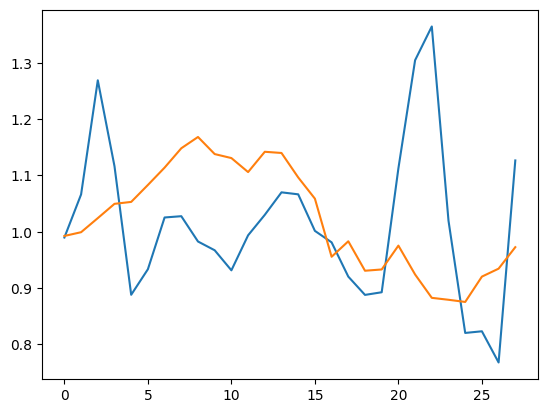

In [12]:
plt.plot(valid_data['target_1'].tolist()[:28])
plt.plot([x[0] for x in all_preds])